In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using controlnet for brain-mask controlled image generatoin

This tutorial illustrates how to use MONAI Generative Models for training a 2D anomaly detection using DDIMs [1]. By leveraging recent advances in generative diffusion probabilistic models, we synthesize counterfactuals of "How would a patient appear if X pathology was not present?". The difference image between the observed patient state and the healthy counterfactual can be used for inferring the location of pathology. We generate counterfactuals that correspond to the minimal change of the input such that it is transformed to healthy domain. We create these counterfactual diffusion models by manipulating the generation process with implicit guidance.

In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Anomaly detection with the trained model

This method results in anomaly heatmaps. It is weakly supervised. The information about labels is not fed to the model as segmentation masks but as a scalar signal (is there an anomaly or not), which is used to guide the diffusion process.

During inference, the model generates a counterfactual image, which is then compared to the original image. The difference between the two images is used to generate an anomaly heatmap.

[1] - Sanchez et al. [What is Healthy? Generative Counterfactual Diffusion for Lesion Localization](https://arxiv.org/abs/2207.12268). DGM 4 MICCAI 2022

## Setup imports

In [2]:
import os
import tempfile
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet, ControlNet
from generative.networks.schedulers import DDPMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print_config()

2023-05-04 00:09:31,344 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
MONAI version: 1.2.dev2304
Numpy version: 1.23.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/mark/Envs/monai-generative/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.12.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-r

## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup BRATS Dataset  - Transforms for extracting 2D slices from 3D volumes

We now download the BraTS dataset and extract the 2D slices from the 3D volumes. The `slice_label` is used to indicate whether the slice contains an anomaly or not.

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the brain images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
3.  The first `Lambdad` transform chooses the first channel of the image, which is the T1-weighted image.
4. `Spacingd` resamples the image to the specified voxel spacing, we use 3,3,2 mm to match the original paper.
5. `ScaleIntensityRangePercentilesd` Apply range scaling to a numpy array based on the intensity distribution of the input. Transform is very common with MRI images.
6. `RandSpatialCropd` randomly crop out a 2D patch from the 3D image.
6. The last `Lambdad` transform obtains `slice_label` by summing up the label to have a single scalar value (healthy `=1` or not `=2` ).

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(3.0, 3.0, 2.0), mode="bilinear"),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["image"], times=1, names=["mask"]),
        transforms.Lambdad(keys=["mask"], func=lambda x: torch.where(x > 0.1, 1, 0)),
        transforms.FillHolesd(keys=["mask"]),
        transforms.CastToTyped(keys=["mask"], dtype=np.float32),


    ]
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


### Load Training and Validation Datasets

In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,
    seed=0,
    transform=train_transforms,
)
print(f"Length of val data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

2023-05-04 00:09:40,150 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-05-04 00:09:40,150 - INFO - File exists: /home/mark/data_drive/monai_data_dir/Task01_BrainTumour.tar, skipped downloading.
2023-05-04 00:09:40,151 - INFO - Non-empty folder exists in /home/mark/data_drive/monai_data_dir/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [01:39<00:00,  3.91it/s]


Length of training data: 388
Train image shape torch.Size([1, 64, 64])
Length of val data: 96
Validation Image shape torch.Size([1, 64, 64])


In [7]:
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

### Visualise the images

batch shape: torch.Size([64, 1, 64, 64])


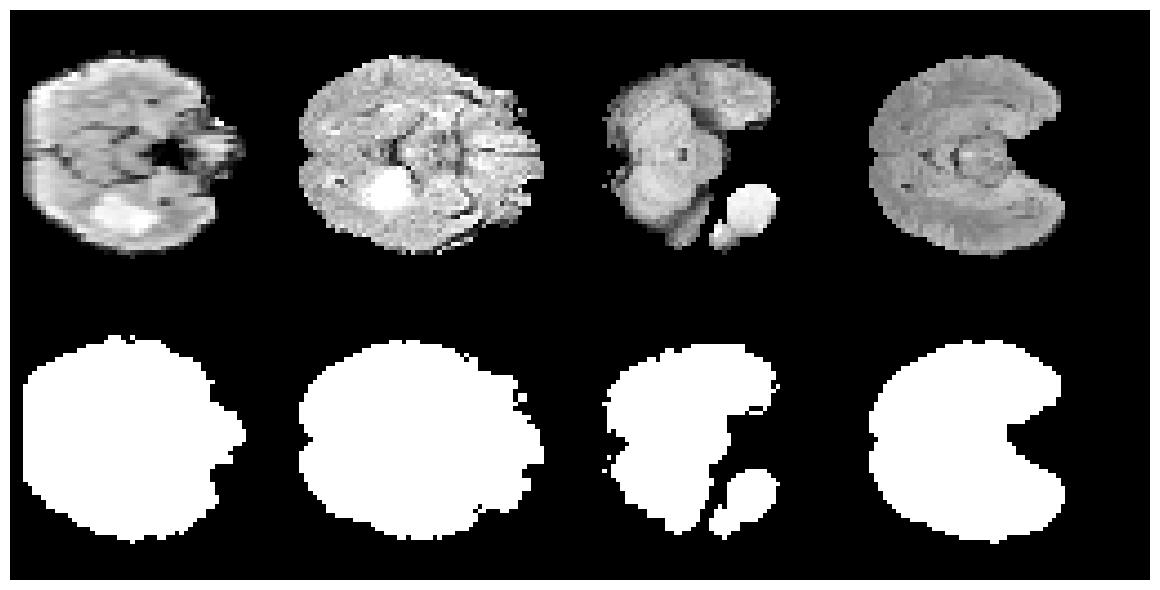

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    (torch.cat([check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1),
    torch.cat([check_data["mask"][0, 0], check_data["mask"][1, 0], check_data["mask"][2, 0], check_data["mask"][3, 0]], dim=1)),
    dim=0)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDIM, the UNET with conditioning, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms.

The `attention` mechanism is essential for ensuring good conditioning and images manipulation here.

An `embedding layer`, which is also optimised during training, is used in the original work because it was empirically shown to improve conditioning compared to a single scalar information.


In [9]:

device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

## Train the diffusion model

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.99it/s]


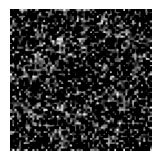

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.20it/s]


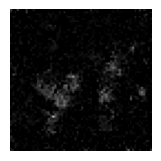

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.74it/s]


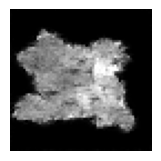

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.38it/s]


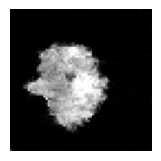

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.59it/s]


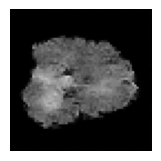

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.47it/s]


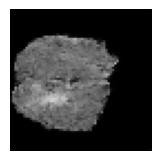

train completed, total time: 666.1393661499023.


In [10]:
n_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Set up the ControlNet

In [11]:
# Create control net
controlnet = ControlNet(    spatial_dims=2,
                        in_channels=1,
                        num_channels=(128, 256, 256),
                        attention_levels=(False, True, True),
                        num_res_blocks=1,
                        num_head_channels=256,
                        conditioning_embedding_num_channels=(16,)
                        )
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(model.state_dict(), strict = False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model. 
for p in model.parameters():
    p.requires_grad = False 
optimizer = torch.optim.Adam(params = controlnet.parameters(), lr=2.5e-5)


## Train the ControlNet

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.89it/s]


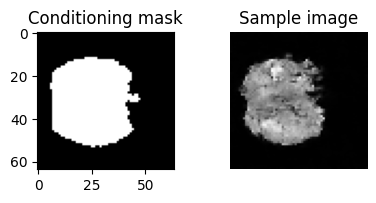

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.46it/s]


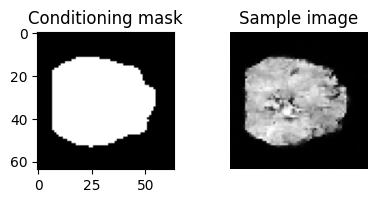

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.23it/s]


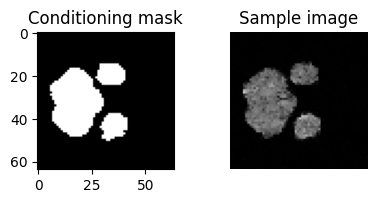

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.65it/s]


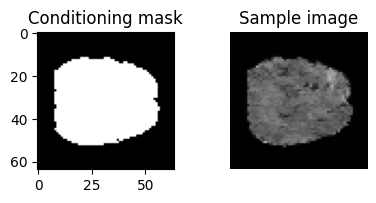

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.98it/s]


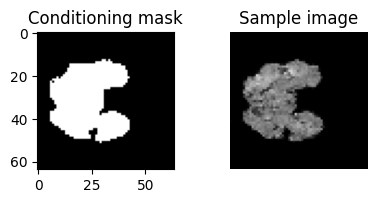

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.96it/s]


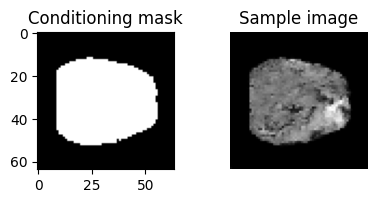

train completed, total time: 769.2119507789612.


In [12]:
n_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):

                
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()
            
            images_noised = scheduler.add_noise(images, noise=noise,timesteps=timesteps)

            # Get controlnet output
            down_block_res_samples, mid_block_res_sample = controlnet(
            x=images_noised,
            timesteps=timesteps,
            controlnet_cond = masks
            )
            # Get model prediction
            noise_pred = model(x=images_noised,
                               timesteps=timesteps,       
                               down_block_additional_residuals = down_block_res_samples,
                               mid_block_additional_residual = mid_block_res_sample)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            break
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training with controlnet conditioning
        progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110)
        progress_bar_sampling.set_description("sampling...")
        sample = torch.randn((1, 1, 64, 64)).to(device)
        for t in progress_bar_sampling:
            with torch.no_grad():
                with autocast(enabled=True):
                    down_block_res_samples, mid_block_res_sample = controlnet(x=sample,
                                                                          timesteps=torch.Tensor((t,)).to(device).long(),
                                                                          controlnet_cond=masks[0,None,...])
                    noise_pred = model(
                        sample,
                        timesteps=torch.Tensor((t,)).to(device),
                        down_block_additional_residuals=down_block_res_samples,
                        mid_block_additional_residual=mid_block_res_sample)
                    sample, _ = scheduler.step(model_output=noise_pred,
                                            timestep=t,
                                            sample=sample)


        plt.subplots(1,2,figsize=(4, 2))
        plt.subplot(1,2,1)
        plt.imshow(masks[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.title('Conditioning mask')
        plt.subplot(1,2,2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.title('Sample image')
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [13]:
sample.dtype

torch.float32